## Efficiency comparison: CLI Vs. Python API 

This section compares the computing efficiency of the original Fortran CLI (`hv_orig`) and the Python API (`hvswdpy.hv`) for computing H/V curves.

- Read the layered model from `examples/model.txt`.
- Compute HV with both implementations.
- Benchmark runtime with warm-ups and repeated runs.
- Plot and summarize results.


In [1]:
# Setup: build CLI if missing and ensure Python API import
import os
import sys
from pathlib import Path
import subprocess

import time
import statistics as stats
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Resolve absolute paths from the running notebook location

EXAMPLES_DIR = Path.cwd().resolve()
ROOT = EXAMPLES_DIR.parent
SRC = ROOT / 'src'
BIN = ROOT / 'bin'
BIN.mkdir(exist_ok=True)

# Ensure Python can import from src if not installed
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Try import
try:
    import hvswdpy as hv
except Exception as e:
    print('Import failed, attempting to build Python extension via setup.py ...')
    subprocess.run([sys.executable, 'setup.py', 'build_ext', '--inplace'], cwd=str(SRC), check=True)
    import hvswdpy as hv

# Ensure CLI binary exists; build from src per Makefile (user prefers building in src)
hv_cli = BIN / 'hv_orig'
if not hv_cli.exists():
    print('CLI not found, building via make hv_orig in src ...')
    subprocess.run(['make', 'hv_orig'], cwd=str(SRC), check=True)
    assert hv_cli.exists(), 'Expected hv_orig to be built in bin/'

# Stable alias for the CLI executable to avoid shadowing later
HV_EXE = hv_cli

print('Setup complete.')

Setup complete.


In [2]:
# Helpers: model I/O and CLI/API runners
import numpy as np
from typing import Tuple

def read_model(path: Path) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    n = int(lines[0])
    vp, vs, rho, th = [], [], [], []
    for i in range(1, n + 1):
        t, a, b, d = lines[i].split()
        if i < n:
            th.append(float(t))
        vp.append(float(a))
        vs.append(float(b))
        rho.append(float(d))
    return (np.array(vp, dtype=np.float64),
            np.array(vs, dtype=np.float64),
            np.array(rho, dtype=np.float64),
            np.array(th, dtype=np.float64))


def run_cli_hv(model_file: Path, *, nf=100, fmin=0.1, fmax=10.0, nmr=20, nml=20, prec=0.0001, nks=0):
    cmd = [
        str(HV_EXE),
        '-f', str(model_file),
        '-fmin', str(fmin),
        '-fmax', str(fmax),
        '-nf', str(nf),
        '-logsam',
        '-nmr', str(nmr),
        '-nml', str(nml),
        '-prec', str(prec),
        '-nks', str(nks),
        '-hv',
    ]
    # CLI writes HV pairs to stdout; capture to text and parse
    res = subprocess.run(cmd, cwd=str(EXAMPLES_DIR), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if res.returncode != 0:
        raise RuntimeError(f'CLI failed: {res.stderr}')
    arr = np.fromstring(res.stdout, sep=' ')
    if arr.size % 2 != 0:
        raise ValueError('Unexpected HV stdout format from CLI')
    pairs = arr.reshape(-1, 2)
    return pairs[:, 0], pairs[:, 1]


def compute_api_hv(vp, vs, rho, th, *, nf=100, fmin=0.1, fmax=10.0, nmr=20, nml=20, prec=0.1, nks=0):
    freq = np.logspace(np.log10(fmin), np.log10(fmax), nf)
    hv_vals, status = hv.hv(
        frequencies_hz=freq,
        vp=vp, vs=vs, rho=rho, thickness=th,
        n_rayleigh_modes=nmr, n_love_modes=nml, precision_percent=prec, nks=nks)
    return freq, hv_vals


In [3]:
MODEL = EXAMPLES_DIR / 'model.txt'
assert MODEL.exists(), f'Model file not found: {MODEL}'

params = dict(nf=100, fmin=0.1, fmax=10.0, nmr=20, nml=20, prec=1, nks=0)

vp, vs, rho, th = read_model(MODEL)

# Warm-up runs
_ = run_cli_hv(MODEL, **params)
_ = compute_api_hv(vp, vs, rho, th, **params)

REPEATS = 5000

cli_times = []
api_times = []

for _ in range(REPEATS):
    t0 = time.perf_counter()
    cli_f, cli_hv = run_cli_hv(MODEL, **params)
    cli_times.append(time.perf_counter() - t0)

for _ in range(REPEATS):
    t0 = time.perf_counter()
    api_f, api_hv = compute_api_hv(vp, vs, rho, th, **params)
    api_times.append(time.perf_counter() - t0)

cli_mean, cli_std = stats.mean(cli_times), stats.pstdev(cli_times)
api_mean, api_std = stats.mean(api_times), stats.pstdev(api_times)

speedup = cli_mean / api_mean if api_mean > 0 else float('inf')

print('CLI mean ± std (s):', round(cli_mean, 5), '±', round(cli_std, 5))
print('API mean ± std (s):', round(api_mean, 5), '±', round(api_std, 5))
print('Speedup (CLI/API):', round(speedup, 2), 'x')


CLI mean ± std (s): 0.0072 ± 0.00137
API mean ± std (s): 0.00232 ± 0.0002
Speedup (CLI/API): 3.11 x


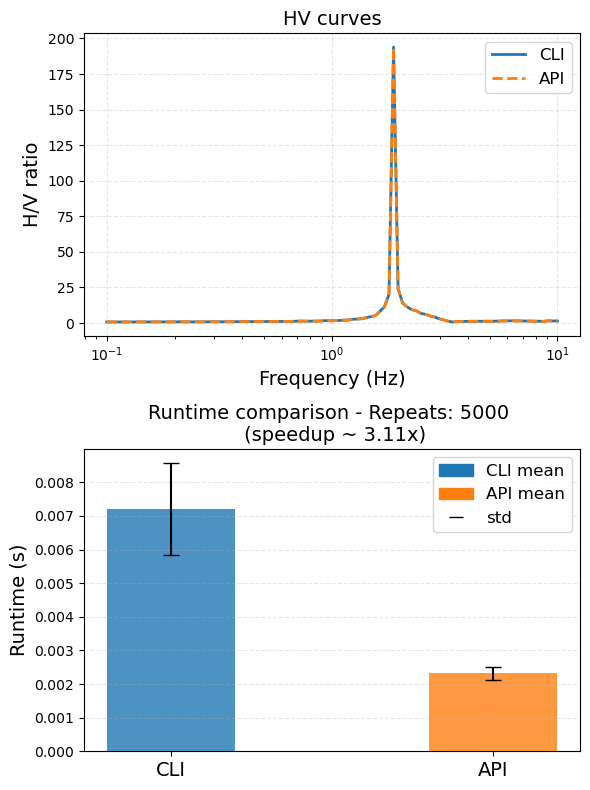

In [4]:
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

# Plot HV curves and a runtime bar chart
fig, ax = plt.subplots(2, 1, figsize=(6, 8))

# HV comparison (interpolate if frequency vectors differ)
if not np.allclose(cli_f, api_f):
    api_hv_plot = np.interp(cli_f, api_f, api_hv)
    x = cli_f
else:
    api_hv_plot = api_hv
    x = api_f

ax[0].semilogx(cli_f, cli_hv, label='CLI', lw=2)
ax[0].semilogx(x, api_hv_plot, '--', label='API', lw=2)
ax[0].set_xlabel('Frequency (Hz)',fontsize=14)
ax[0].set_ylabel('H/V ratio',fontsize=14)
ax[0].grid(True, linestyle='dashed', alpha=0.3)
ax[0].legend(fontsize=12)
ax[0].set_title('HV curves',fontsize=14)

# Runtime bar chart
labels = ['CLI', 'API']
means = [cli_mean, api_mean]
errs = [cli_std, api_std]
bars = ax[1].bar(labels, means, yerr=errs, color=['C0', 'C1'], width=0.4, alpha=0.8, capsize=6)
ax[1].tick_params(axis='x', labelsize=14)
ax[1].set_ylabel('Runtime (s)',fontsize=14)
ax[1].set_title(f'Runtime comparison - Repeats: {REPEATS} \n (speedup ~ {speedup:.2f}x)',fontsize=14)
cli_patch = mpatches.Patch(color='C0', label='CLI mean')
api_patch = mpatches.Patch(color='C1', label='API mean')
err_proxy = Line2D([0], [0], color='k', marker='_', linestyle='None', markersize=10, label='std')
ax[1].legend(handles=[cli_patch, api_patch, err_proxy], loc='best',fontsize=12)
ax[1].grid(True, linestyle='dashed', axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## Efficiency comparison: `hvswdpy` Vs. `Disba` 

This notebook benchmarks runtime for computing Rayleigh and Love phase-velocity dispersion curves using:

- [hvswdpy](https://github.com/Shihao-Yuan/SWD-HV-DFA)
- [Disba](https://github.com/keurfonluu/disba)


We sweep the number of frequency samples and report median wall-clock time over several repeats for each solver and wave type.


In [5]:
# Setup
import sys, time
from time import perf_counter
from statistics import median
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

SCRIPT_DIR = Path.cwd().resolve()
ROOT = SCRIPT_DIR.parent
SRC_PATH = ROOT / 'src'

try:
    import hvswdpy as hv
except ModuleNotFoundError:
    sys.path.insert(0, str(SRC_PATH))
    import hvswdpy as hv

try:
    from disba import PhaseDispersion
except ModuleNotFoundError as e:
    raise ModuleNotFoundError("Install DISBA with `pip install disba`." ) from e


In [6]:
def read_model(path: Path):
    with open(path, 'r') as f:
        lines = [ln.strip() for ln in f if ln.strip()]
    n = int(lines[0])
    vp, vs, rho, th = [], [], [], []
    for i in range(1, n + 1):
        t, a, b, d = lines[i].split()
        if i < n:
            th.append(float(t))
        vp.append(float(a))
        vs.append(float(b))
        rho.append(float(d))
    return (
        np.array(vp, dtype=float),
        np.array(vs, dtype=float),
        np.array(rho, dtype=float),
        np.array(th, dtype=float),
    )

VP, VS, RHO, TH = read_model(SCRIPT_DIR / 'model.txt')
print('Loaded model with', VP.size, 'layers (including half-space).')


Loaded model with 2 layers (including half-space).


In [7]:
N_RAY_MODES = 1
N_LOVE_MODES = 1
PREC = 1  # percent

FMIN, FMAX = 0.5, 30.0
GRID_SIZES = [100, 400, 800, 1600, 3200]
REPEATS = 5  # repeats per point to compute median

print('Grid sizes:', GRID_SIZES)
print('Repeats per size:', REPEATS)

Grid sizes: [100, 400, 800, 1600, 3200]
Repeats per size: 5


In [8]:
def time_hv_dispersion(freq):
    t0 = perf_counter()
    disp = hv.dispersion(
        frequencies_hz=freq,
        vp=VP, vs=VS, rho=RHO, thickness=TH,
        n_rayleigh_modes=N_RAY_MODES, n_love_modes=N_LOVE_MODES,
        precision_percent=PREC,
    )
    _ = disp.rayleigh_slowness, disp.love_slowness
    return perf_counter() - t0

# DISBA takes km, km/s, g/cm^3, and periods ascending
th_km = np.append(TH, 0.0) / 1000.0
vp_kms = VP / 1000.0
vs_kms = VS / 1000.0
rho_gcm3 = RHO / 1000.0

pd_ray = PhaseDispersion(th_km, vp_kms, vs_kms, rho_gcm3,dc=0.005)
pd_lov = PhaseDispersion(th_km, vp_kms, vs_kms, rho_gcm3,dc=0.005)

def time_disba_dispersion(freq):
    per = (1.0 / freq)[::-1]
    t0 = perf_counter()
    # Rayleigh and Love fundamental only for timing fairness; you can extend to modes if desired
    _ = pd_ray(per, wave='rayleigh', mode=0).velocity
    _ = pd_lov(per, wave='love', mode=0).velocity
    return perf_counter() - t0


In [9]:
# Warm-up
freq_warm = np.logspace(np.log10(1.0), np.log10(10.0), 50)
_ = time_hv_dispersion(freq_warm)
_ = time_disba_dispersion(freq_warm)
print('Warm-up done.')


Warm-up done.


In [14]:
# Benchmark loops
hv_times = []
disba_times = []
for nf in GRID_SIZES:
    freq = np.logspace(np.log10(FMIN), np.log10(FMAX), nf)
    # repeat and take median
    hv_rep = [time_hv_dispersion(freq) for _ in range(REPEATS)]
    disba_rep = [time_disba_dispersion(freq) for _ in range(REPEATS)]
    hv_times.append(median(hv_rep))
    disba_times.append(median(disba_rep))
    print(f"nf={nf:4d}: HV={hv_times[-1]*1e3:.2f} ms, DISBA={disba_times[-1]*1e3:.2f} ms")

hv_times = np.array(hv_times)
disba_times = np.array(disba_times)


nf= 100: HV=0.31 ms, DISBA=0.56 ms
nf= 400: HV=1.05 ms, DISBA=1.89 ms
nf= 800: HV=1.89 ms, DISBA=3.45 ms
nf=1600: HV=3.77 ms, DISBA=6.52 ms
nf=3200: HV=7.86 ms, DISBA=12.94 ms


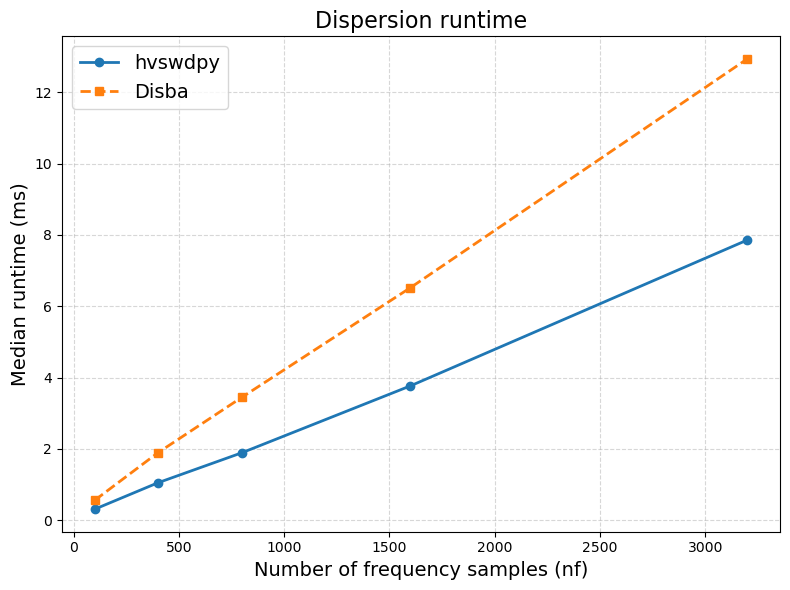

In [15]:
# Plot timing vs number of frequencies
plt.figure(figsize=(8, 6))
plt.plot(GRID_SIZES, hv_times*1e3, 'o-', lw=2, label='hvswdpy')
plt.plot(GRID_SIZES, disba_times*1e3, 's--', lw=2, label='Disba')
plt.xlabel('Number of frequency samples (nf)',fontsize=14)
plt.ylabel('Median runtime (ms)',fontsize=14    )
plt.title('Dispersion runtime',fontsize=16)
plt.grid(True, linestyle='dashed', alpha=0.5)
plt.legend(ncol=1, fontsize=14,loc=2)
plt.tight_layout()
plt.show()
